In [2]:
import sys
import os
import cv2
import matplotlib.pyplot as plt
import psutil
import numpy as np
import pandas as pd
import torch

# Add the root of the project to the path
sys.path.append(os.path.abspath("D:\\burtm\\Visual_studio_code\\PD_related_projects"))

In [3]:
source_path="D:\\burtm\\Visual_studio_code\\PD_related_projects"
#train_df = pd.read_csv(f"{source_path}\\outputs\\preprocessed_data\\icdar_train_df_w_image_paths.csv")
train_df = pd.read_csv(f"{source_path}\\outputs\\preprocessed_data\\icdar_train_df_20250514_175905.csv")

In [3]:
train_df.head()

,writer,isEng,same_text,file_name,male,train,index
0,1,0,0,D:\download\PD project\datasets\ICDAR 2013 - G...,0,1,0
1,1,0,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0,1,1
2,1,1,0,D:\download\PD project\datasets\ICDAR 2013 - G...,0,1,2
3,1,1,1,D:\download\PD project\datasets\ICDAR 2013 - G...,0,1,3
4,2,0,0,D:\download\PD project\datasets\ICDAR 2013 - G...,0,1,4


In [171]:
test_i=44 #3, 30, 130, 1100 (arab), 515, 5, 16, 32, 35, 44 (don't work)
file_path = train_df.loc[test_i, 'file_name']
# Load the image in grayscale
img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

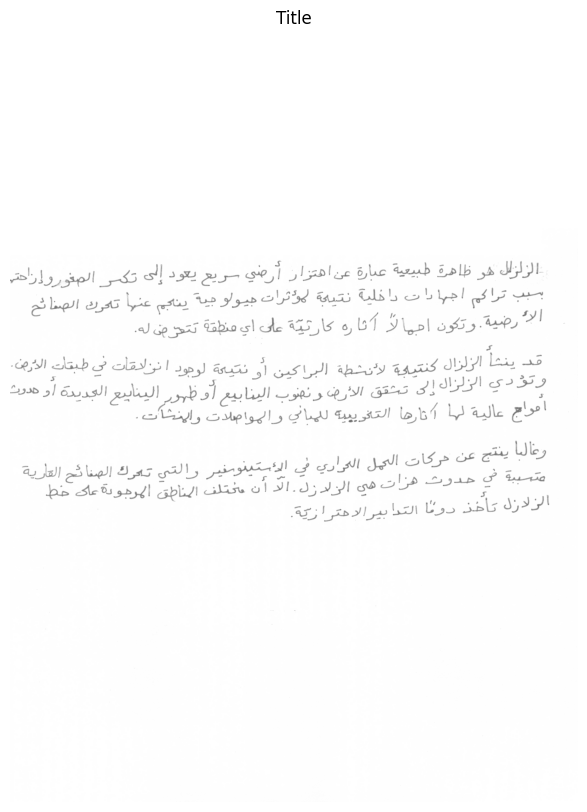

In [100]:
def plot_image(image, convert=False):
    # Convert the image to RGB for plotting
    if convert:
        image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    else:
        image_rgb = image.copy()
    # Plot the image with keypoints
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title("Title")
    plt.show()
plot_image(img, convert=True)

# projection profile approach

Horizontal Projection shape: (3365,)


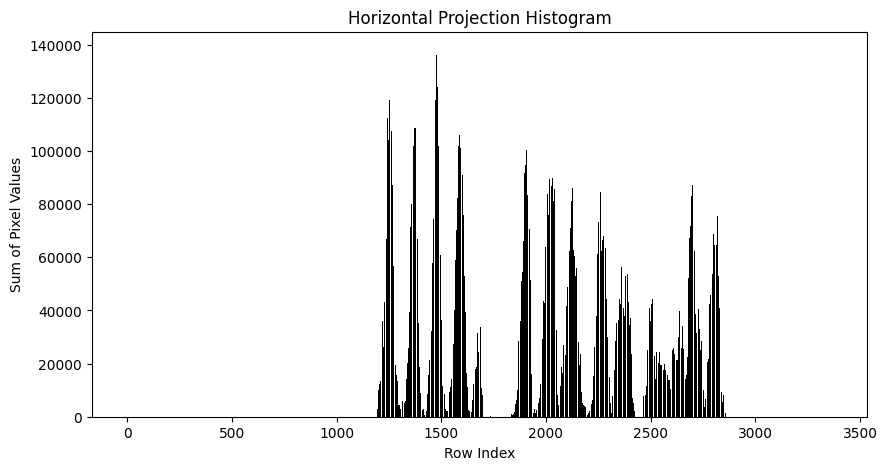

In [ ]:
# Step 1: Binarize the image using adaptive threshold
binary = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                            cv2.THRESH_BINARY_INV, 15, 10)
#plot_image(binary, convert=True)

# Step 2: Line segmentation using horizontal projection
horizontal_projection = np.sum(binary, axis=1)
print("Horizontal Projection shape:", horizontal_projection.shape)
plt.figure(figsize=(10, 5))
plt.bar(range(len(horizontal_projection)), horizontal_projection, color='black')
plt.title("Horizontal Projection Histogram")
plt.xlabel("Row Index")
plt.ylabel("Sum of Pixel Values")
plt.show()

lines = []
start = None
min_sum = 0.1 * np.max(horizontal_projection)  # Minimum sum to consider a line

for i, row_sum in enumerate(horizontal_projection):
    if row_sum > min_sum and start is None:
        start = i
    elif row_sum < min_sum and start is not None:
        lines.append((start, i))
        start = None

if start is not None:
    lines.append((start, len(binary)))

In [9]:
# Step 3: Segment lines and within each line, segment words
line_images = []
word_images = []

for idx, (y1, y2) in enumerate(lines):
    line_img = binary[y1:y2, :]
    line_images.append((y1,y2))

    # Word segmentation using vertical projection on each line
    vertical_projection = np.sum(line_img, axis=0)
    word_start = None
    words_in_line = []

    for j, col_sum in enumerate(vertical_projection):
        if col_sum > 0 and word_start is None:
            word_start = j
        elif col_sum == 0 and word_start is not None and j - word_start > 200:
            words_in_line.append((word_start, j))
            word_start = None

    if word_start is not None:
        words_in_line.append((word_start, line_img.shape[1]))

    # Extract words from the line image
    for w_idx, (x1, x2) in enumerate(words_in_line):
        #word_img = line_img[:, x1:x2]
        word_images.append((y1, y2, x1, x2))
        # Optionally show or save each word
        # show_image(f"Line {idx+1} Word {w_idx+1}", word_img)

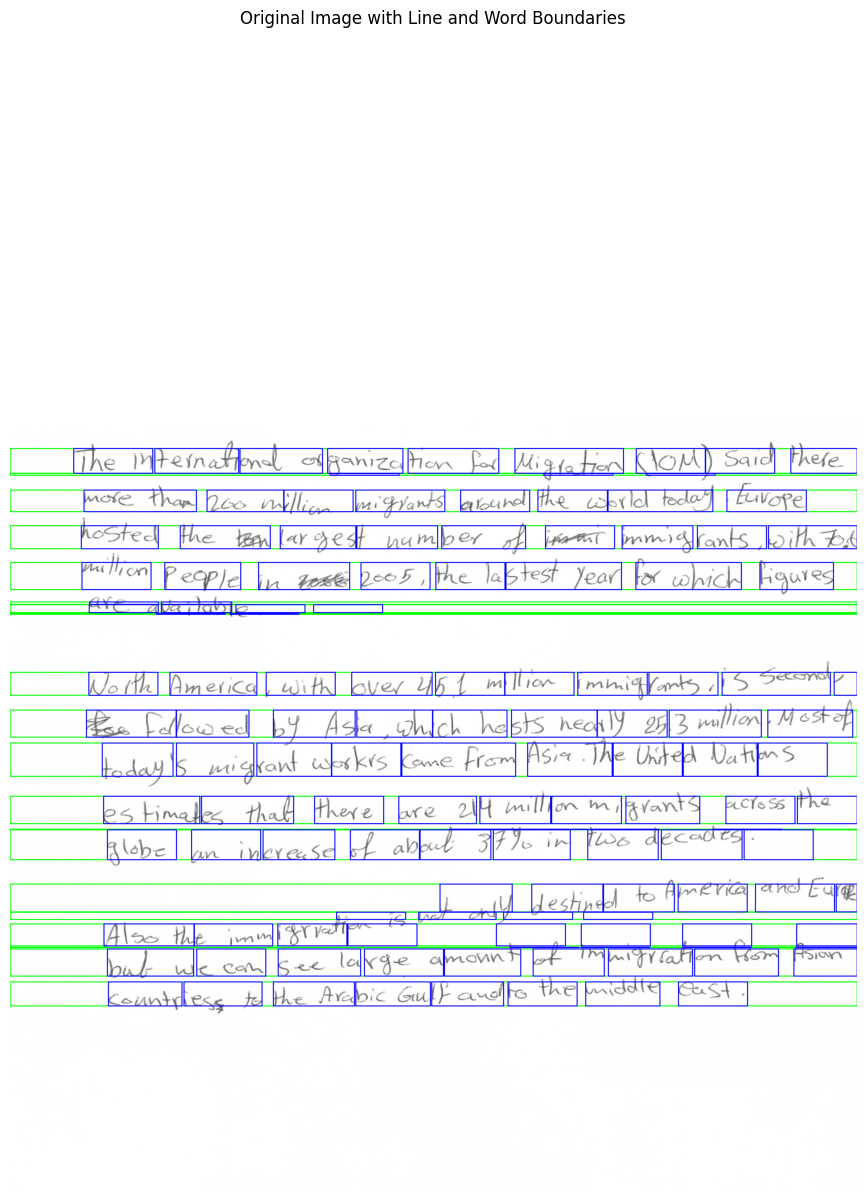

In [10]:
# Create a copy of the original image to draw on
image_with_boxes = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

# Draw line boundaries
for y1, y2 in lines:
    cv2.rectangle(image_with_boxes, (0, y1), (image_with_boxes.shape[1], y2), (0, 255, 0), 2)

# Draw word bounding boxes
for y1, y2, x1, x2 in word_images:
    cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), (255, 0, 0), 2)

# Plot the image with the bounding boxes
plt.figure(figsize=(15, 15))
plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Original Image with Line and Word Boundaries")
plt.show()

# connected components approach

In [6]:
binary = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY_INV, 15, 10)

# Step 1: Connected Components Analysis
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)

# Filter out small noise blobs
min_area = 16*16  # tweak based on image resolution
components = []
for i in range(1, num_labels):  # skip background
    x, y, w, h, area = stats[i]
    if area >= min_area:
        components.append((x, y, w, h, area))

# Step 2: Group into lines by y-coordinate proximity
components.sort(key=lambda b: b[1])  # sort by y (top of bounding box)
lines = []
line_threshold = 20  # vertical spacing threshold in pixels

start_y = components[0][1] #y coordinate of the highest bounding box
last_y = start_y
last_y2 = start_y
for comp in components:
    x, y, w, h, _ = comp
    assigned = False
    if y - start_y < line_threshold:
        last_y = y
        last_y2 = y + h
    else:
        lines.append((start_y,last_y2))
        start_y = y
        last_y = start_y

378

In [22]:
bounding_boxes = []
for comp in components:
    x, y, w, h, _ = comp
    bounding_boxes.append((x, y, x+w, y+h))

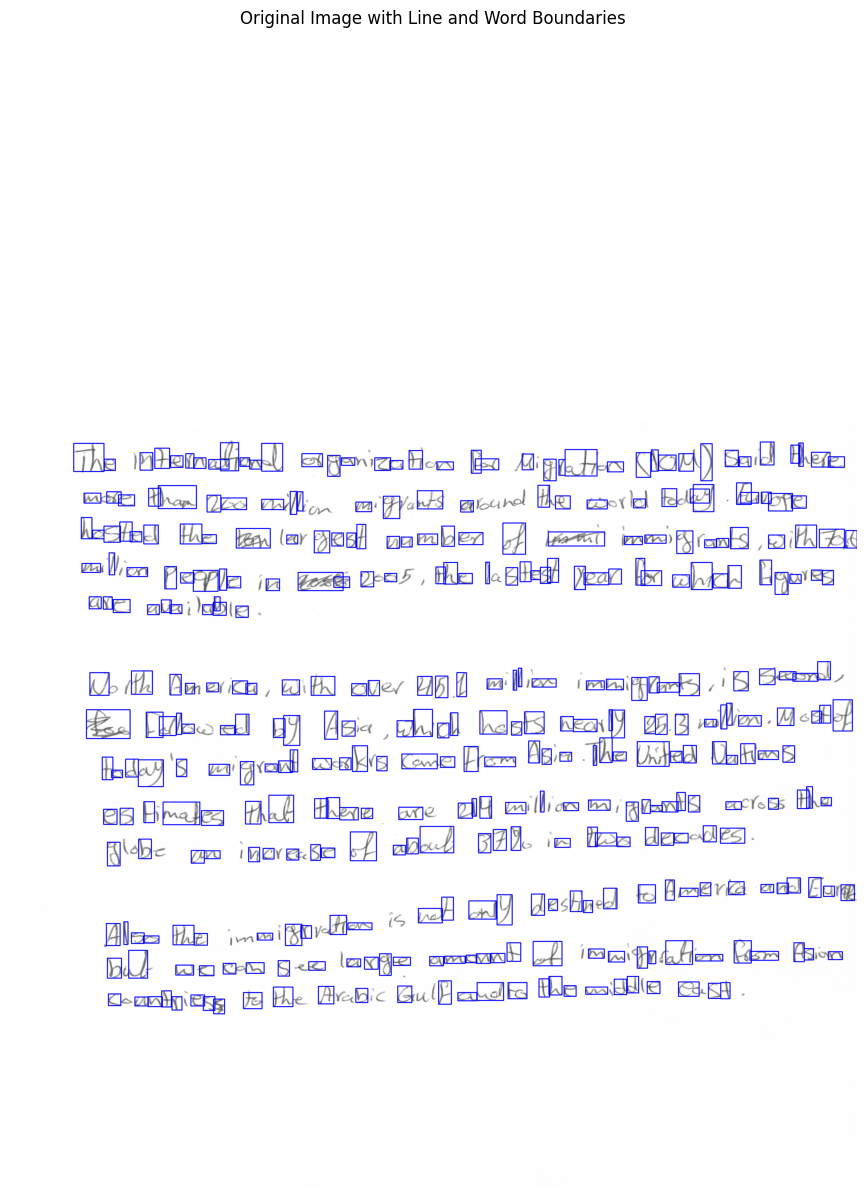

In [23]:
plot_bounding_boxes(img, bounding_boxes)

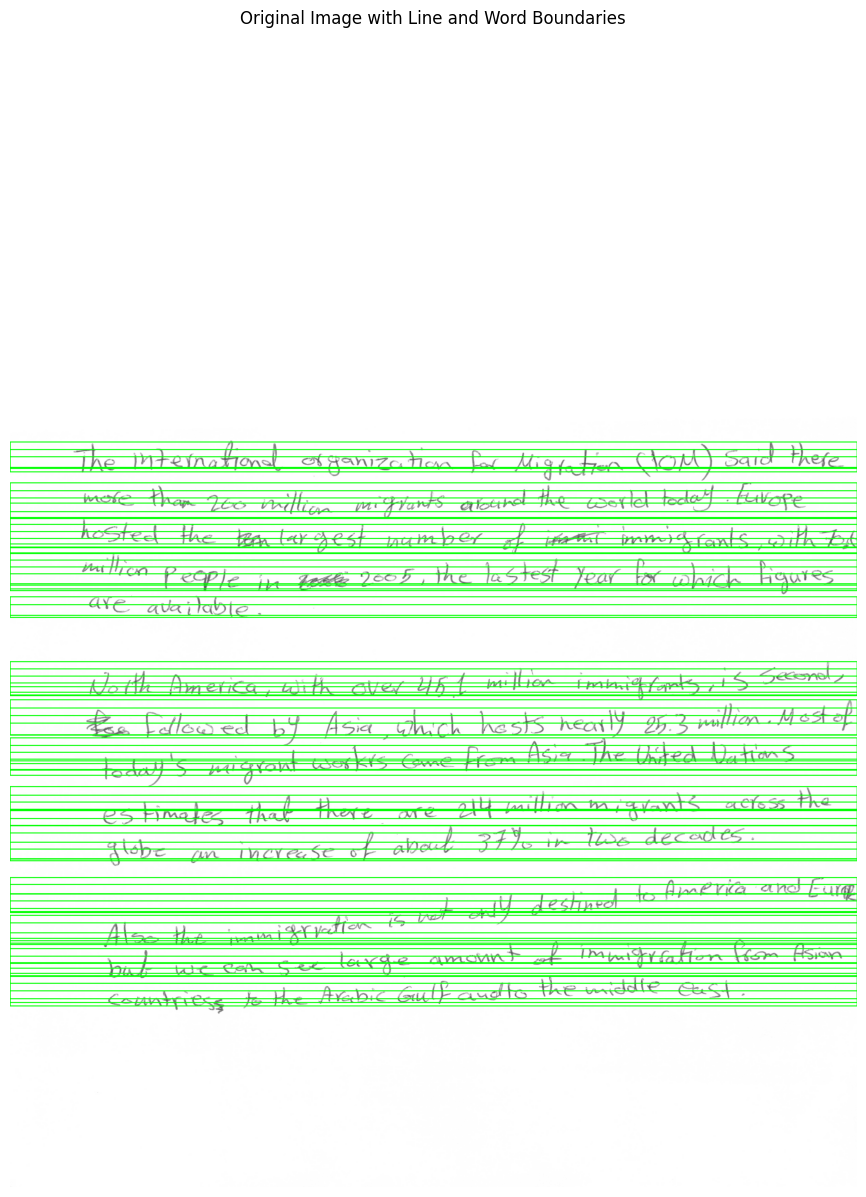

In [25]:
plot_lines(img, lines)

In [ ]:
# Step 3: Within each line, group into words by x-coordinate gaps
word_images = []

for i, line in enumerate(lines):
    boxes = sorted(line['boxes'], key=lambda b: b[0])  # sort by x
    word = [boxes[0]]
    for j in range(1, len(boxes)):
        prev = boxes[j - 1]
        curr = boxes[j]
        gap = curr[0] - (prev[0] + prev[2])
        if gap < 30:  # horizontal threshold for word gap
            word.append(curr)
        else:
            word_images.append(word)
            word = [curr]
    word_images.append(word)  # add last word

    # Optionally visualize words in line
    for k, word_box_group in enumerate(word_images):
        xs = [b[0] for b in word_box_group]
        ys = [b[1] for b in word_box_group]
        ws = [b[2] for b in word_box_group]
        hs = [b[3] for b in word_box_group]

        x1 = min(xs)
        y1 = min(ys)
        x2 = max([x + w for x, w in zip(xs, ws)])
        y2 = max([y + h for y, h in zip(ys, hs)])

        word_img = binary[y1:y2, x1:x2]
        show_image(f"Line {i+1} Word {k+1}", word_img)

# word/sentence custom segmentation

The problem: i have a series of centroids. The y is between y_min,y_max the x is between x_min, x_max
The centroids have a regularity, they can be organized in lines. But the lines are not necessarily straight, they may be curved or oblique.
How do i connect the centroids so that they form lines?

Actually I only want "sentences" -> from a given image I want 5 fragments that contain 10 connected components each (the connected components being on the same line)  

idea 1: compute the distance of each point from every other point and the angle of the line that links them. For each point find the next point (the next point is the closest point for which the angle doesn't exceed a threshold).

idea 2: sort the centroids by y. Take the highest centroid. Consider all the centroids that have y>y_highest-dy (dy median height of a connected component). Sort the centroids by x. Link the centroids until there is a space longer than 3*dx (median width of centroids)

idea 3: sort by y. Take the first centroid. Go on until y-dy. Sort by x. Take all the centroids that are in x_0+2dx. 
If you add a centroid that is already labelled label the others with the same label

idea 4: split in 3 the page. Use projection profiles to identify lines on each slice. 

idea 5: I get the histogram peaks and the width of histograms and i define lines centered on the center with width given by a fraction of the histogram width

## idea 4

In [231]:
test_i=35 #3, 30, 130, 1100 (arab), 515, 5, 16, 32, 35, 44 
file_path = train_df.loc[test_i, 'file_name']
# Load the image in grayscale
img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

In [232]:
height, width = img.shape
n_slices= 3
patches = [[] for _ in range(n_slices)]
projections = [[] for _ in range(n_slices)]
patch_width = width // n_slices
lines_in_patch = [[] for _ in range(n_slices)]

for i in range(n_slices):
    x1 = i * patch_width
    x2 = (i + 1) * patch_width if i < 2 else width  # last patch takes the rest
    patch = img[:, x1:x2]
    patches[i] = patch
    # Step 1: Binarize the image using adaptive threshold
    binary = cv2.adaptiveThreshold(patch, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY_INV, 15, 10)
    #_, binary = cv2.threshold(patch, 180, 255, cv2.THRESH_BINARY_INV)
    horizontal_projection = np.sum(binary, axis=1)
    projections[i] = horizontal_projection
    lines = []
    start = None
    '''non_zero_vals = horizontal_projection[horizontal_projection > 0]
    ten_smallest = np.sort(non_zero_vals)[:100]
    min_sum = np.max(ten_smallest)  # Minimum sum to consider a line'''
    min_sum=0.5* np.mean(horizontal_projection)

    for j, row_sum in enumerate(horizontal_projection):
        if row_sum > min_sum and start is None:
            start = j
        elif row_sum < min_sum and start is not None:
            lines.append((start, j))
            start = None

    if start is not None:
        lines.append((start, len(binary)))
    lines_in_patch[i] = lines

In [233]:
'''i=1
print_horizontal_projection(projections[i])
plot_lines(patches[i],lines_in_patch[i])'''

'i=1\nprint_horizontal_projection(projections[i])\nplot_lines(patches[i],lines_in_patch[i])'

In [234]:
import numpy as np
n_selected_lines = 3
selected_lines = [[] for _ in range(n_slices)]
spacing = 15
for i in range(n_slices):
    lines = lines_in_patch[i]
    width = np.array([l[1]-l[0] for l in lines])
    '''median_width = np.median(width)
    for j in range(n_selected_lines):
        closest_idx = np.argmin(np.abs(np.array(width) - median_width))
        width[closest_idx] = 0
        selected_lines[i].append(lines[closest_idx])'''
    max_width = np.max(width)
    mask= width>0.1*max_width
    filtered_widths = width[mask]
    width[~mask] = 0
    median_width = np.median(filtered_widths)
    for j in range(n_selected_lines):
        closest_idx = np.argmin(np.abs(np.array(width) - median_width))
        width[closest_idx] = 0
        selected_lines[i].append((lines[closest_idx][0]-spacing, lines[closest_idx][1]+spacing))
    '''for j in range(len(filtered_widths)):
        closest_idx = np.argmin(np.abs(np.array(width) - median_width))
        width[closest_idx] = 0
        y_start, y_end = lines[closest_idx]
        region = patches[i][y_start:y_end, :]
        black_amount = np.sum(region == 255)
        total_pixels = region.size
        black_ratio = black_amount / total_pixels
        if black_ratio > 0.01:
            selected_lines[i].append((lines[closest_idx][0]-spacing, lines[closest_idx][1]+spacing))
        if len(selected_lines[i]) >= n_selected_lines:
            break'''
    #selected_indices = np.random.choice(possible_indices, size=min(n_selected_lines, len(possible_indices)), replace=False)
    #The number of elements to select is the smaller of n_selected_lines (the desired number of lines) 
    # and the number of available indices in possible_indices.
    #This prevents errors if there are fewer possible indices than n_selected_lines
    '''for idx in selected_indices:
        selected_lines[i].append((lines[idx][0]-spacing, lines[idx][1]+spacing))'''

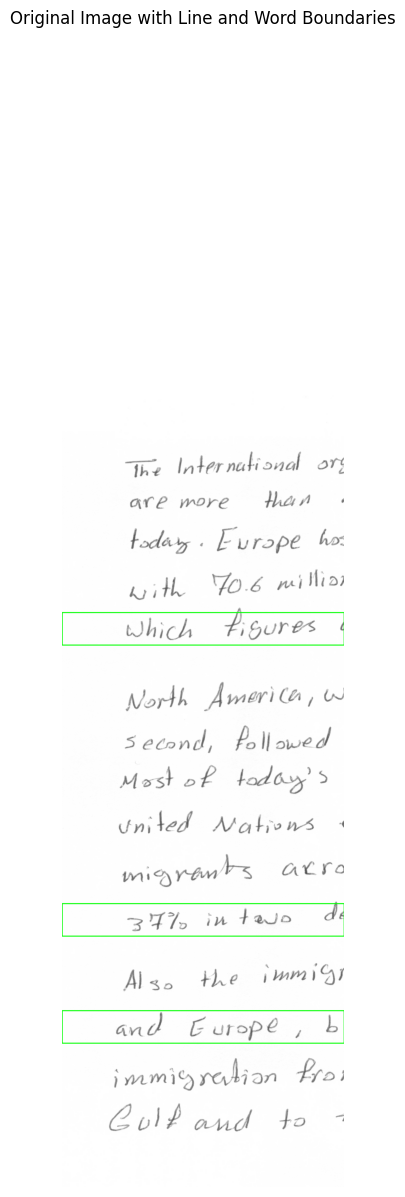

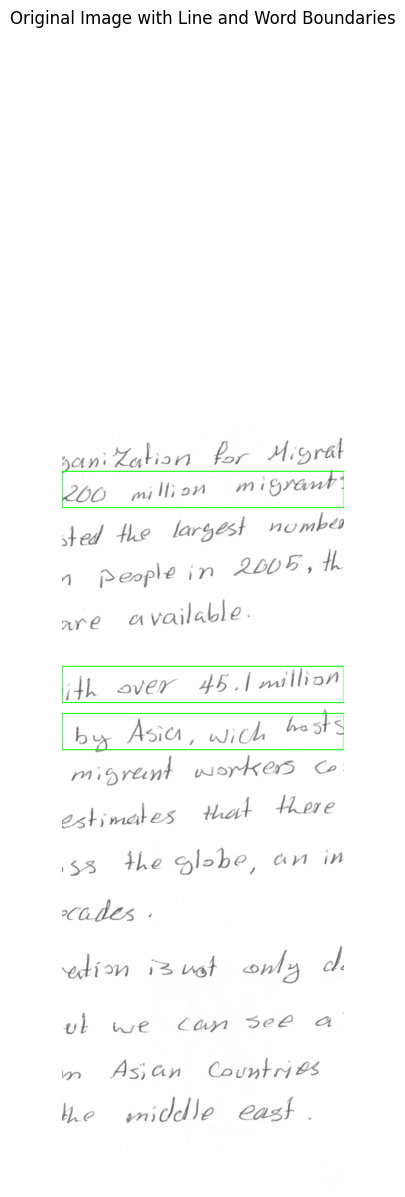

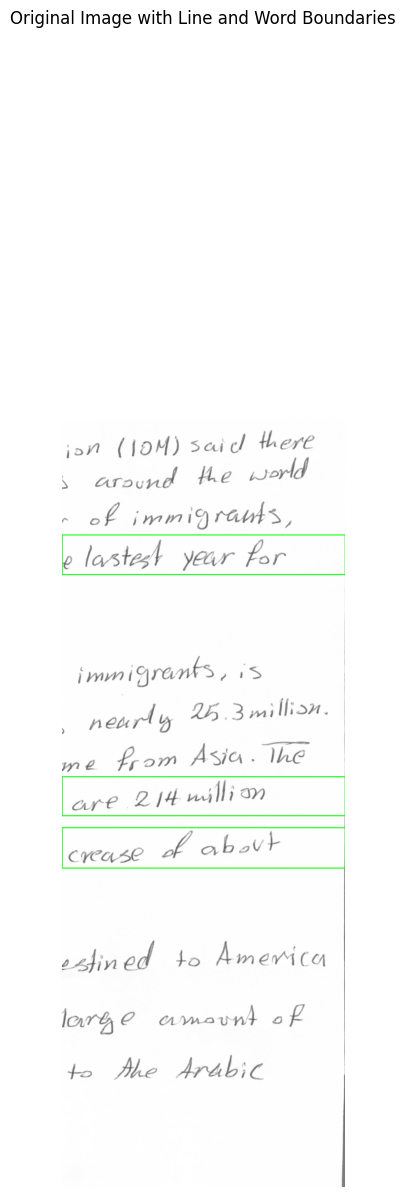

In [235]:
for i in range(n_slices):
    plot_lines(patches[i],selected_lines[i])

## idea 5

I get the histogram peaks and the width of histograms and i define lines centered on the center with width given by a fraction of the histogram width

Horizontal Projection shape: (3365,)


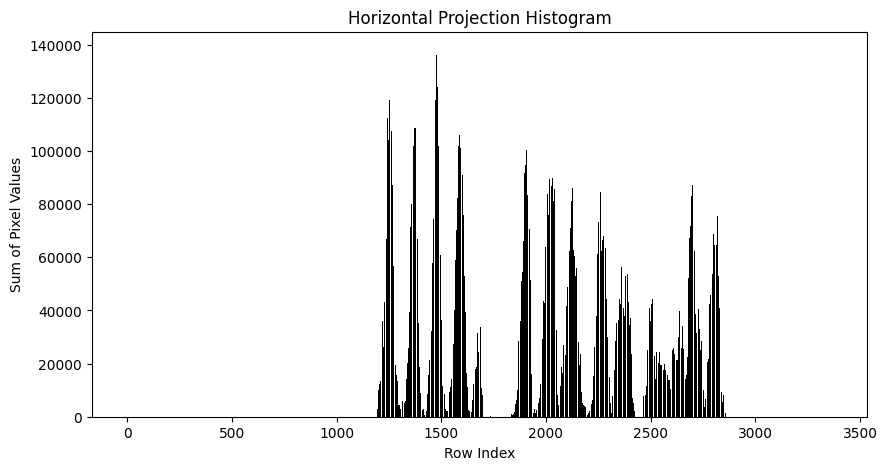

In [ ]:
# Step 1: Binarize the image using adaptive threshold
binary = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                            cv2.THRESH_BINARY_INV, 15, 10)
#plot_image(binary, convert=True)

# Step 2: Line segmentation using horizontal projection
horizontal_projection = np.sum(binary, axis=1)
print_horizontal_projection(horizontal_projection)


In [ ]:
#fit gaussians
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

# Define a sum of n Gaussians
def multi_gaussian(x, *params):
    n = len(params) // 3
    y = np.zeros_like(x, dtype=float)
    for i in range(n):
        amp = params[3*i]
        mu = params[3*i+1]
        sigma = params[3*i+2]
        y += amp * np.exp(-(x - mu)**2 / (2 * sigma**2))
    return y

x = np.arange(len(horizontal_projection))
y = horizontal_projection

# Estimate n by counting peaks (between 10 and 20)
peaks, _ = find_peaks(y, height=0.1 * np.max(y), distance=10)
n = np.clip(len(peaks), 10, 20)

# Initial guess: amplitude, mean, std for each Gaussian
init_params = []
for i in range(n):
    if i < len(peaks):
        amp = y[peaks[i]]
        mu = peaks[i]
    else:
        amp = np.max(y)
        mu = x[int(len(x) * i / n)]
    sigma = 10
    init_params += [amp, mu, sigma]

# Fit the histogram
popt, _ = curve_fit(lambda x, *params: multi_gaussian(x, *params), x, y, p0=init_params, maxfev=10000)

# Plot the result
plt.figure(figsize=(12, 6))
plt.bar(x, y, color='gray', alpha=0.5, label='Histogram')
plt.plot(x, multi_gaussian(x, *popt), 'r-', label=f'Fitted {n} Gaussians')
plt.legend()
plt.title(f'Fit of Histogram with {n} Gaussians')
plt.xlabel('Row Index')
plt.ylabel('Sum of Pixel Values')
plt.show()

Peaks at indices: [1229 1244 1257 1273 1289 1336 1363 1374 1393 1444 1462 1474 1492 1546
 1568 1582 1594 1613 1661 1673 1687 1875 1885 1906 1918 1979 1997 2016
 2027 2039 2084 2108 2125 2135 2145 2165 2237 2259 2273 2288 2301 2328
 2338 2350 2361 2387 2403 2495 2511 2532 2543 2557 2567 2577 2605 2619
 2638 2650 2673 2686 2699 2716 2731 2742 2769 2781 2793 2806 2818 2830]


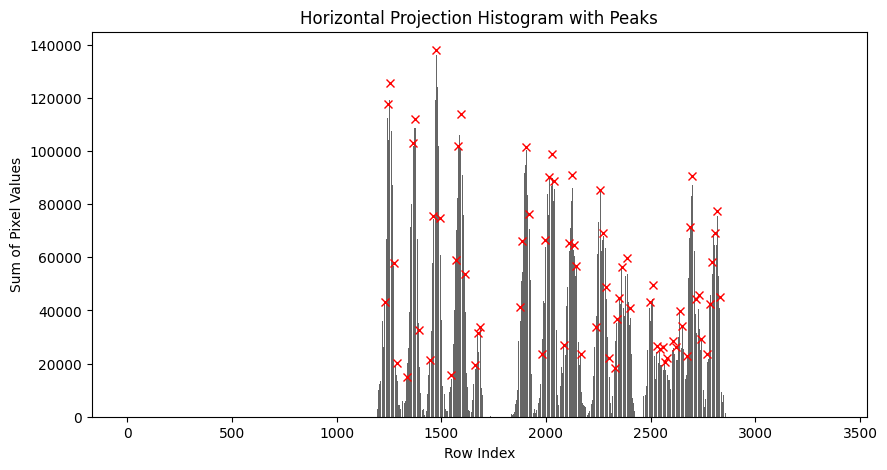

In [8]:
# Find peaks in the horizontal projection histogram
peaks, properties = find_peaks(horizontal_projection, height=0.1 * np.max(horizontal_projection), distance=10)

print("Peaks at indices:", peaks)
plt.figure(figsize=(10, 5))
plt.bar(range(len(horizontal_projection)), horizontal_projection, color='black', alpha=0.6)
plt.plot(peaks, horizontal_projection[peaks], "rx")
plt.title("Horizontal Projection Histogram with Peaks")
plt.xlabel("Row Index")
plt.ylabel("Sum of Pixel Values")
plt.show()

In [ ]:
lines = []
start = None
min_sum = 0.1 * np.max(horizontal_projection)  # Minimum sum to consider a line

for i, row_sum in enumerate(horizontal_projection):
    if row_sum > min_sum and start is None:
        start = i
    elif row_sum < min_sum and start is not None:
        lines.append((start, i))
        start = None

if start is not None:
    lines.append((start, len(binary)))

# functions

In [184]:
def plot_lines(img,lines):
    # Create a copy of the original image to draw on
    image_with_boxes = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # Draw line boundaries
    for y1, y2 in lines:
        cv2.rectangle(image_with_boxes, (0, y1), (image_with_boxes.shape[1], y2), (0, 255, 0), 2)

    # Plot the image with the bounding boxes
    plt.figure(figsize=(15, 15))
    plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Original Image with Line and Word Boundaries")
    plt.show()

In [10]:
def print_horizontal_projection(horizontal_projection):
    print("Horizontal Projection shape:", horizontal_projection.shape)
    plt.figure(figsize=(10, 5))
    plt.bar(range(len(horizontal_projection)), horizontal_projection, color='black')
    plt.title("Horizontal Projection Histogram")
    plt.xlabel("Row Index")
    plt.ylabel("Sum of Pixel Values")
    plt.show()

In [11]:
def plot_bounding_boxes(img,word_images):
    # Create a copy of the original image to draw on
    image_with_boxes = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

    # Draw word bounding boxes
    for x1, y1, x2, y2 in word_images:
        cv2.rectangle(image_with_boxes, (x1, y1), (x2, y2), (255, 0, 0), 2)

    # Plot the image with the bounding boxes
    plt.figure(figsize=(15, 15))
    plt.imshow(cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Original Image with Line and Word Boundaries")
    plt.show()

# test trocr

In [5]:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
from PIL import Image
import requests

# load image from the IAM database
'''url = 'https://fki.tic.heia-fr.ch/static/img/a01-122-02-00.jpg'
image = Image.open(requests.get(url, stream=True).raw).convert("RGB")'''
# Select one word image from the word_images list

#processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-handwritten')
#processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-handwritten',force_download=True) #force download clear the cache and redownload the model
processor = TrOCRProcessor.from_pretrained('microsoft/trocr-small-handwritten',use_fast=False)

d:\burtm\Visual_studio_code\conda_environments\GeneralPurposeML\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-small-handwritten')

Config of the encoder: <class 'transformers.models.deit.modeling_deit.DeiTModel'> is overwritten by shared encoder config: DeiTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 384,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 1536,
  "layer_norm_eps": 1e-12,
  "model_type": "deit",
  "num_attention_heads": 6,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": true,
  "transformers_version": "4.48.2"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 384,
  "d_model": 256,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 1024,
  "decode

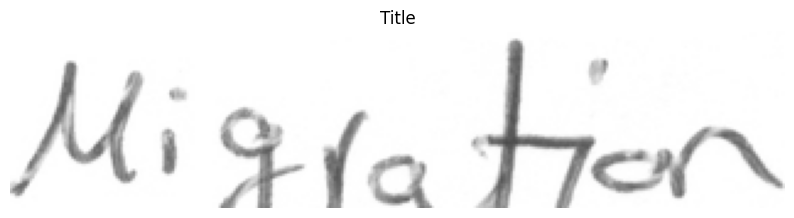

In [11]:
for i in range(len(word_images)):
    y1, y2, x1, x2 = word_images[i]
    if x2-x1 > 300:  # Filter out small components
        word_img = img[y1:y2, x1:x2]
        break
    else:
        pass

# Convert the selected word image to RGB format
image = cv2.cvtColor(word_img, cv2.COLOR_GRAY2RGB)
plot_image(image, convert=False)

In [12]:
height, width = img.shape
print(f"Image Height: {height}, Image Width: {width}")

Image Height: 3365, Image Width: 2465


In [13]:
pixel_values = processor(images=image, return_tensors="pt").pixel_values

In [26]:
print(processor)

TrOCRProcessor:
- image_processor: DeiTImageProcessor {
  "crop_size": {
    "height": 224,
    "width": 224
  },
  "do_center_crop": false,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "DeiTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 3,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 384,
    "width": 384
  }
}

- tokenizer: XLMRobertaTokenizer(name_or_path='microsoft/trocr-small-handwritten', vocab_size=64002, model_max_length=1000000000000000019884624838656, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=

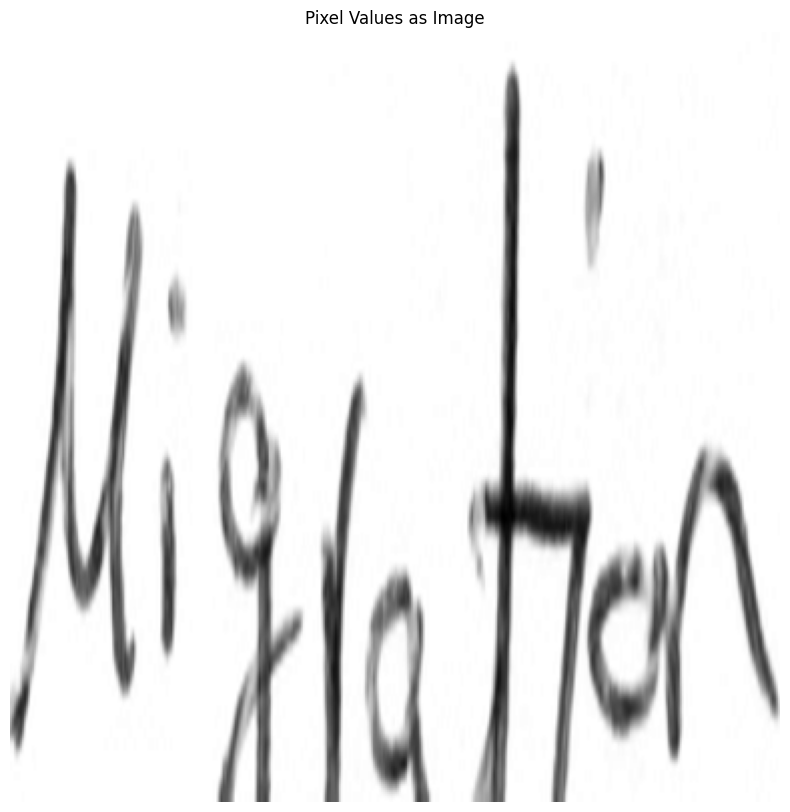

In [14]:
# Convert pixel_values tensor to NumPy array
pixel_values_np = pixel_values.squeeze().permute(1, 2, 0).numpy()

# Normalize to 0-255 for visualization
pixel_values_np = (pixel_values_np - pixel_values_np.min()) / (pixel_values_np.max() - pixel_values_np.min()) * 255
pixel_values_np = pixel_values_np.astype(np.uint8)

# Plot the image
plt.figure(figsize=(10, 10))
plt.imshow(pixel_values_np)
plt.axis('off')
plt.title("Pixel Values as Image")
plt.show()

In [15]:
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

In [16]:
print(generated_text)

Migration


In [59]:
print(model)


VisionEncoderDecoderModel(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTSdpaAttention(
            (attention): DeiTSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense):

In [ ]:
print(model.config)


VisionEncoderDecoderConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "microsoft/trocr-small-handwritten",
  "architectures": [
    "VisionEncoderDecoderModel"
  ],
  "decoder": {
    "_attn_implementation_autoset": false,
    "_name_or_path": "",
    "activation_dropout": 0.0,
    "activation_function": "relu",
    "add_cross_attention": true,
    "architectures": null,
    "attention_dropout": 0.0,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": 0,
    "chunk_size_feed_forward": 0,
    "classifier_dropout": 0.0,
    "cross_attention_hidden_size": 384,
    "d_model": 256,
    "decoder_attention_heads": 8,
    "decoder_ffn_dim": 1024,
    "decoder_layerdrop": 0.0,
    "decoder_layers": 6,
    "decoder_start_token_id": 2,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "dropout": 0.1,
    "early_stopping": false,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": 2,
    "exponential_decay_length_penalty": null,
    "f

In [61]:
print(model.encoder.config.use_cls_token if hasattr(model.encoder.config, "use_cls_token") else "No cls token info")

No cls token info


In [17]:
outputs = model.encoder(pixel_values=pixel_values)
last_hidden_state = outputs.last_hidden_state  # shape: (batch_size, sequence_length, hidden_size)
print("Last hidden state shape:", last_hidden_state.shape)

Last hidden state shape: torch.Size([1, 578, 384])


In [18]:
patch_size = model.encoder.config.patch_size  # e.g., 16
image_size = model.encoder.config.image_size  # e.g., 224

num_patches = (image_size // patch_size) ** 2
print(num_patches)

576


In [19]:
from torch import nn

# Define the classifier model
class Classifier(nn.Module):
    def __init__(self, encoder, num_classes=2):
        super(Classifier, self).__init__()
        self.encoder = encoder
        self.classification_head = nn.Linear(encoder.config.hidden_size, num_classes)

    def forward(self, pixel_values):
        outputs = self.encoder(pixel_values=pixel_values)
        cls_token_output = outputs.last_hidden_state[:, 0, :]  # Extract the CLS token
        logits = self.classification_head(cls_token_output)
        return logits

# Create the classifier model
classifier = Classifier(model.encoder)

# Delete the original model to free up memory
del model

In [ ]:
print(classifier)


Classifier(
  (encoder): DeiTModel(
    (embeddings): DeiTEmbeddings(
      (patch_embeddings): DeiTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DeiTEncoder(
      (layer): ModuleList(
        (0-11): 12 x DeiTLayer(
          (attention): DeiTSdpaAttention(
            (attention): DeiTSdpaSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DeiTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DeiTIntermediate(
            (dense): Linear(in_feat

In [82]:
print(classifier.encoder)

DeiTModel(
  (embeddings): DeiTEmbeddings(
    (patch_embeddings): DeiTPatchEmbeddings(
      (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): DeiTEncoder(
    (layer): ModuleList(
      (0-11): 12 x DeiTLayer(
        (attention): DeiTSdpaAttention(
          (attention): DeiTSdpaSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): DeiTSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): DeiTIntermediate(
          (dense): Linear(in_features=384, out_features=1536, bias=True)
          (intermediate_act_fn)

In [76]:
for name, param in classifier.encoder.named_parameters():
    print(name)

embeddings.cls_token
embeddings.distillation_token
embeddings.position_embeddings
embeddings.patch_embeddings.projection.weight
embeddings.patch_embeddings.projection.bias
encoder.layer.0.attention.attention.query.weight
encoder.layer.0.attention.attention.query.bias
encoder.layer.0.attention.attention.key.weight
encoder.layer.0.attention.attention.key.bias
encoder.layer.0.attention.attention.value.weight
encoder.layer.0.attention.attention.value.bias
encoder.layer.0.attention.output.dense.weight
encoder.layer.0.attention.output.dense.bias
encoder.layer.0.intermediate.dense.weight
encoder.layer.0.intermediate.dense.bias
encoder.layer.0.output.dense.weight
encoder.layer.0.output.dense.bias
encoder.layer.0.layernorm_before.weight
encoder.layer.0.layernorm_before.bias
encoder.layer.0.layernorm_after.weight
encoder.layer.0.layernorm_after.bias
encoder.layer.1.attention.attention.query.weight
encoder.layer.1.attention.attention.query.bias
encoder.layer.1.attention.attention.key.weight
encod

In [ ]:
'''# Freeze all layers except the last self-attention module and the following layers
for name, param in classifier.encoder.named_parameters():
    if "layer.11" not in name and "layernorm" not in name and "pooler" not in name:
        param.requires_grad = False''' #i think in this way it would not freeze also many other layers because of 
#the name "layernorm" and "pooler"

In [83]:
def return_trainable_params(classifier):
    return sum(p.numel() for p in classifier.parameters() if p.requires_grad)

In [ ]:
'''#print the number of trainable parameters in the model
print("Number of trainable parameters in the model:")
trainable_params = return_trainable_params(classifier)
print(trainable_params)
#freeze all model parameters and print the trainable layers 
for name, param in classifier.named_parameters():
    param.requires_grad = False  # Freeze all parameters
print("Trainable parameters after freezing:")
trainable_params = return_trainable_params(classifier)
print(trainable_params)
# Unfreeze the last self-attention module and the following layers
classifier.encoder.encoder.layer[-1].requires_grad = True  # Unfreeze the last layer
classifier.encoder.layernorm.requires_grad = True  # Unfreeze the layer norm
classifier.encoder.pooler.requires_grad = True  # Unfreeze the pooler
classifier.classification_head.requires_grad = True  # Unfreeze the classification head
print("Trainable parameters after unfreezing:")
trainable_params = return_trainable_params(classifier)
print(trainable_params)'''

Number of trainable parameters in the model:
0
Trainable parameters after freezing:
0
Trainable parameters after unfreezing:
0


In [ ]:
# Iterate through the layers of a PyTorch model
from torch import nn

def print_model_layers(model):
    for name, module in model.named_modules():
        print(f"Layer Name: {name}, Layer Type: {type(module).__name__}")

# Example usage with the classifier model
print_model_layers(classifier)